In [4]:
import pandas as pd
import os
import regex as re
from datetime import datetime
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
import numpy as np
from lda import LDA
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import CountVectorizer
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))


In [ ]:
def query_string_gen(file_dir, words):
    l=[]

    with open(file_dir, 'r') as file:
        lines = file.readlines()
    for line in lines:
        for word in words:
            if word in line:
                l.append(re.search(r'\d+', line).group())
    l = list(dict.fromkeys(l))

    string = ""
    for i,j in enumerate(l):
        if i==len(l)-1:
            string += f"Topic == {j}"
        else:
            string += f"Topic == {j} | "
    return string

# Correlation

array([<AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>,
       <AxesSubplot:xlabel='EVENT_DATE'>], dtype=object)

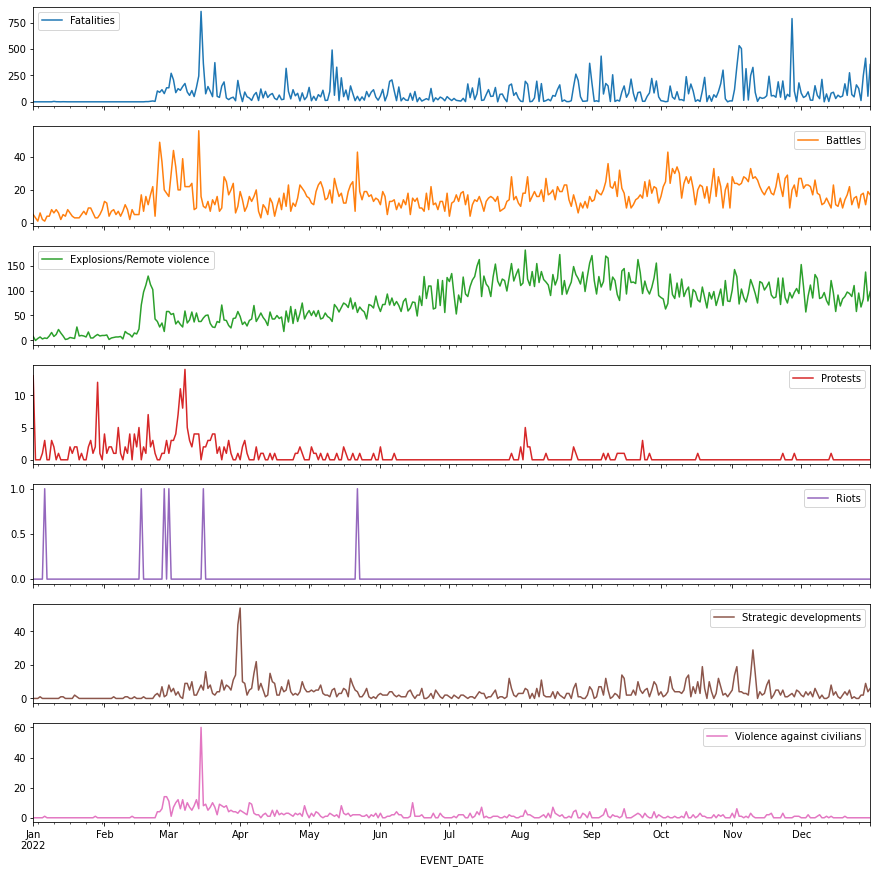

In [81]:

events = pd.read_csv(os.path.join(ROOT_DIR,"data","Ukraine_Black_Sea_2020_2023_Jan20.csv"), parse_dates=["EVENT_DATE"], index_col="EVENT_DATE")
events = events[["FATALITIES","EVENT_TYPE","LOCATION","NOTES"]].loc["2022-01-01":"2022-12-31"].sort_index()
# events = events.query("FATALITIES > 50")
# events.iloc[50:100,:]
events = events[["EVENT_TYPE","FATALITIES"]].rename(columns={"EVENT_DATE":"Date","EVENT_TYPE":"Count","FATALITIES":"Fatalities"})  # pegando somente colunas relevantes
events = pd.get_dummies(events, columns=["Count"], prefix="", prefix_sep="")  # transformando em dummies
events = events.resample("D").sum()

# plot all columns in events
events.plot(subplots=True, figsize=(15,15))


In [50]:
def spearman_gen(dir,source,resample,pval,kind,date_start,date_end):
    events = pd.read_csv(os.path.join(ROOT_DIR,"data","Ukraine_Black_Sea_2020_2023_Jan20.csv"), parse_dates=["EVENT_DATE"])
    #events = events.query("EVENT_TYPE == 'Strategic developments'")
    events = events[["EVENT_DATE","EVENT_TYPE","FATALITIES"]].rename(columns={"EVENT_DATE":"Date","EVENT_TYPE":"Count","FATALITIES":"Fatalities"})  # pegando somente colunas relevantes
    events = events.sort_index()
    events = events.set_index("Date") # convertendo coluna de datas pra datetime e setando indice
    events = events.loc[date_start:date_end]
    events = events.resample(resample).agg({'Count': 'count', 'Fatalities': 'sum'}) # resample: contagem de eventos, soma de fatalidades


    results = pd.read_csv(os.path.join(dir,f"{source}_Results.csv"), parse_dates=["Date"],index_col=["Date"])
    results = results[["Resonance","Novelty","Transience"]]
    results = results.sort_index()
    results = results.loc[date_start:date_end] # Matching other dataframe
    results = results.resample(resample).sum()
    results[["Count","Fatalities"]] = events[["Count","Fatalities"]].copy()

    s_fatalities, s_fatalities_p = spearmanr(results['Fatalities'], results['Resonance'])
    p_fatalities, p_fatalities_p = pearsonr(results['Fatalities'], results['Resonance'])
    s_events, s_events_p = spearmanr(results['Count'], results['Resonance'])
    p_events, p_events_p = pearsonr(results['Count'], results['Resonance'])

    if s_fatalities_p <= pval and kind == "fat":
        print(f'{source} (R X F) Spearman: {s_fatalities:.4f} p-value: {s_fatalities_p:.4f}')
    if s_events_p <= pval and kind == "eve":
        print(f'{source} (R X CE) Spearman: {s_events:.4f} p-value: {s_events_p:.4f}')

In [46]:
def pearson_gen(dir,source,resample,pval,kind,date_start,date_end):
    events = pd.read_csv(os.path.join(ROOT_DIR,"data","Ukraine_Black_Sea_2020_2022_Dec09-1.csv"), parse_dates=["EVENT_DATE"])
    events = events[["EVENT_DATE","EVENT_TYPE","FATALITIES"]].rename(columns={"EVENT_DATE":"Date","EVENT_TYPE":"Count","FATALITIES":"Fatalities"})  # pegando somente colunas relevantes
    events = events.sort_index()
    events = events.set_index("Date") # convertendo coluna de datas pra datetime e setando indice
    events = events.loc[date_start:date_end]
    events = events.resample(resample).agg({'Count': 'count', 'Fatalities': 'sum'}) # resample: contagem de eventos, soma de fatalidades

    results = pd.read_csv(os.path.join(dir,f"{source}_Results.csv"), parse_dates=["Date"],index_col=["Date"])
    results = results[["Resonance","Novelty","Transience"]]
    results = results.sort_index()
    results = results.loc[date_start:date_end] # Matching other dataframe
    results = results.resample(resample).sum()
    results[["Count","Fatalities"]] = events[["Count","Fatalities"]].copy()

    s_fatalities, s_fatalities_p = spearmanr(results['Fatalities'], results['Resonance'])
    p_fatalities, p_fatalities_p = pearsonr(results['Fatalities'], results['Resonance'])
    s_events, s_events_p = spearmanr(results['Count'], results['Resonance'])
    p_events, p_events_p = pearsonr(results['Count'], results['Resonance'])

    if p_fatalities_p <= pval and kind == "fat":
        print(f'{source} (R X F) Pearson: {p_fatalities:.4f} p-value: {p_fatalities_p:.4f}')
    if p_events_p <= pval and kind == "eve":
        print(f'{source} (R X CE) Pearson: {p_events:.4f} p-value: {p_events_p:.4f}')

In [ ]:

def correlate(dir, source, resample, pval, correlation, compare):
    events = pd.read_csv(os.path.join(ROOT_DIR, "data", "Ukraine_Black_Sea_2020_2022_Nov18.csv"), parse_dates=["EVENT_DATE"])
    events = events[["EVENT_DATE", "EVENT_TYPE", "FATALITIES"]].rename(columns={"EVENT_DATE": "Date", "EVENT_TYPE": "Count", "FATALITIES": "Fatalities"})  # pegando somente colunas relevantes
    events = events.set_index("Date")  # convertendo coluna de datas pra datetime e setando indice
    events = events.resample(resample).agg({"Count": "count", "Fatalities": "sum"})  # resample: contagem de eventos, soma de fatalidades

    results = pd.read_csv(os.path.join(dir, f"{source}_Results.csv"), parse_dates=["Date"], index_col=["Date"])
    results = results[["Resonance", "Novelty", "Transience"]]
    results = results.sort_index()
    results = results.loc["2018-01-01":"2022-11-18"]  # Matching other dataframe
    results = results.resample(resample).sum()
    results[["Count", "Fatalities"]] = events[["Count", "Fatalities"]].copy()
    results = results.loc["2020-01-01":"2022-11-16"]

    s_fatalities, s_fatalities_p = spearmanr(results["Fatalities"], results["Resonance"])
    p_fatalities, p_fatalities_p = pearsonr(results["Fatalities"], results["Resonance"])
    s_events, s_events_p = spearmanr(results["Count"], results["Resonance"])
    p_events, p_events_p = pearsonr(results["Count"], results["Resonance"])

    if correlation == "pearson":
        print("Pearson")
        if p_fatalities_p <= pval and compare == "fat":
            print(f"{source} (R X F) Pearson: {p_fatalities:.4f} p-value: {p_fatalities_p:.4f}")
        if p_events_p <= pval and compare == "eve":
            print(f"{source} (R X CE) Pearson: {p_events:.4f} p-value: {p_events_p:.4f}")

    if correlation == "spearman":
        print("Spearman")
        if s_fatalities_p <= pval and compare == "fat":
            print(f"{source} (R X F) Spearman: {s_fatalities:.4f} p-value: {s_fatalities_p:.4f}")
        if s_events_p <= pval and compare == "eve":
            print(f"{source} (R X CE) Spearman: {s_events:.4f} p-value: {s_events_p:.4f}")

In [51]:
sources = ["AP", "Fox", "CNN", "ABC", "CBS", "NYT", "Mirror", "Reuters", "Express", "HuffPost", "Guardian", "DailyMail", "All"]
variables = ["eve"]
resamples = ["D", "W"]
windows = [7,10,15,20,25,30]
date_start = "2022-03-01"
date_end = "2022-12-09"

print(f"-> Date range: {date_start} to {date_end}")
print("======= SPEARMAN CORRELATION =======")
for variable in variables:
    print(f"---------- Variable: {variable} ----------")
    for resample in resamples:
        print(f"----------- Resample: {resample} -----------")
        for window in windows:
            print(f"-> KLD Window: {window}")
            for source in sources:
                spearman_gen(os.path.join(ROOT_DIR,f"results_{window}"),source,resample,0.05,variable,date_start,date_end)

# print("======= PEARSON CORRELATION =======")
# for variable in variables:
#     print(f"---------- Variable: {variable} ----------")
#     for resample in resamples:
#         print(f"----------- Resample: {resample} -----------")
#         for window in windows:
#             print(f"-> KLD Window: {window}")
#             for source in sources:
#                 pearson_gen(os.path.join(ROOT_DIR,f"results_{window}"),source,resample,0.05,variable,date_start,date_end)

-> Date range: 2022-03-01 to 2022-12-09
======= SPEARMAN CORRELATION =======
---------- Variable: eve ----------
----------- Resample: D -----------
-> KLD Window: 7


ValueError: array must not contain infs or NaNs